# Phase picking

Now we have detected some earthquakes we should do something with them.  We will discuss location of earthquakes in
[the next notebook](3_Earthquake_Location.ipynb), but classical earthquake detection and analysis requires the
accurate identification of seismic phase arrivals.  In this notebook we will look at some picking stratergies and
think about a few automatic pickers implemented in Obspy.

First, lets take an example of an earthquake in the GeoNet catalog and plot the waveforms with the picks overlain.

Event has 204 picks


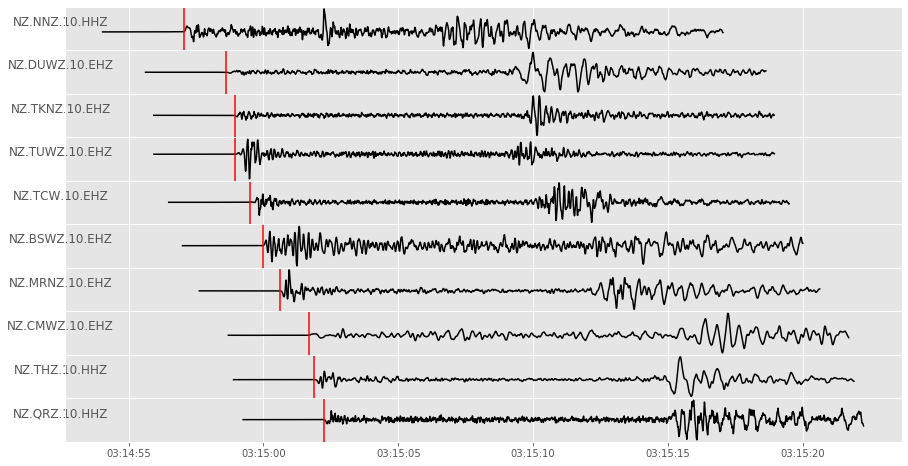

In [1]:
# Notebook set-up
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

from obspy import Stream
from obspy.clients.fdsn import Client

client = Client("GEONET")
cat = client.get_events(eventid="2018p546311")
event = cat[0]
print("Event has {0} picks".format(len(event.picks)))
# We will remove the picks from strong motion sites, they often have poor timing
event.picks = [p for p in event.picks 
               if p.waveform_id.channel_code[0] != "B"]

# Lets just look at the first five picks
picks = sorted(event.picks, key=lambda p: p.time)[0:10]

st = Stream()
for pick in picks:
    tr = client.get_waveforms(
        network=pick.waveform_id.network_code,
        station=pick.waveform_id.station_code,
        location=pick.waveform_id.location_code,
        channel=pick.waveform_id.channel_code,
        starttime=pick.time - 3, 
        endtime=pick.time + 20)
    tr.trim(pick.time - 3, pick.time +20)
    st += tr
st.merge().sort(["starttime"])

def plot_picked(st, picks):
    pick_color = {'P': 'r', 'S': 'b'}
    fig, axes = plt.subplots(nrows=len(st), figsize=(15, 8), sharex=True)
    for tr, ax in zip(st, axes):
        x = np.arange(0, tr.stats.npts)
        x = x * tr.stats.delta
        x = [(tr.stats.starttime + _).datetime for _ in x]
        ax.plot(x, tr.data, 'k')
        ax.set_ylabel(tr.id, rotation=0)
        ax.set_yticks([])
        # Find matching picks and plot them
        for pick in picks:
            if pick.waveform_id.get_seed_string() == tr.id:
                ax.axvline(x=pick.time.datetime, color=pick_color[pick.phase_hint])
    fig.subplots_adjust(wspace=0, hspace=0)
    return fig

fig = plot_picked(st, picks)

Note that GeoNet do not usually pick S-phases.  S-phases are more difficult for automatic pickers to identify correctly,
and can be difficult to pick manually. However, the additional information from S arrivals can greatly improve locations,
particularly for offshore earthquakes (with poor azimuthal coverage).

Lets zoom in on those P-picks.

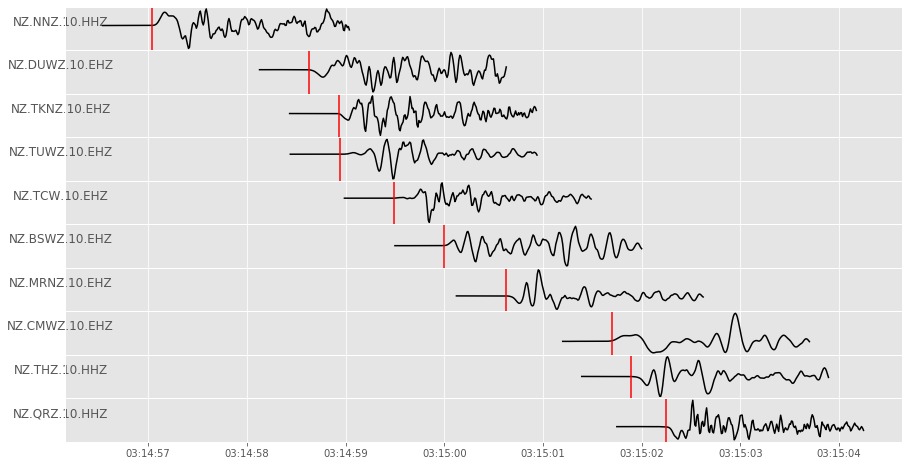

In [2]:
short_st = Stream()
for pick in picks:
    tr = client.get_waveforms(
        network=pick.waveform_id.network_code,
        station=pick.waveform_id.station_code,
        location=pick.waveform_id.location_code,
        channel=pick.waveform_id.channel_code,
        starttime=pick.time - 0.5, 
        endtime=pick.time + 2)
    tr.trim(pick.time - 0.5, pick.time + 2)
    short_st += tr
short_st.merge().sort(["starttime"])
fig = plot_picked(short_st, picks)

From this view we can see that some arrivals are more impulsive than others.  The general rule is to **pick the first break** where
a break is a deviation from the background noise to the earthquake waveform. This will give you the arrival of the first arriving P-phase, 
which can be used to infer the hypocenter; the location that the earthquake started.  Sometimes this first break can be hard to spot
the change, either due to emmergent waveforms (common in media that have strong resonance) or low signal to noise ratios. It is normal
to estimate your pick uncertainty when making manual picks.  This pick uncertainty can be incorporated into earthquake location inversions
to weight the inversion, and to constrain the final location uncertainty.  Remember that earthquake locations are models of where an earthquake
happened, and they have some intrinsic uncertainty associated with them.

## Pick your own

I have written a little interactive plot for you to pick your own waveforms with. You will use this for the assignment as well. Bear in mind that this is a simple application for picking P and S phases. Other software are available and would be recommended for research or commercial purposes because they give you more control and options for picking and uncertainty. Some popular software packages are:
- [Seisan](http://seis.geus.net/software/seisan/seisan.html)
- [SAC](https://ds.iris.edu/files/sac-manual/)
- [Seiscomp](https://www.seiscomp3.org/)
To start with we will download an earthquake of interest and have a go at picking it. You can compare your picks to the GeoNet picks once you are done.

Unfortunately the picking tool does not work in the notebook, so you will have to open a python terminal and
run it there.  I would recommend opening an iPython session, to do this, open a terminal and type `ipython`.  This will start the iPython shell.

The iPython shell allows you to interact with code, much like the notebooks do, but without the text in between.

I have written some code below that you might want to copy into the iPython shell to start you off.

Event has 204 picks
Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button


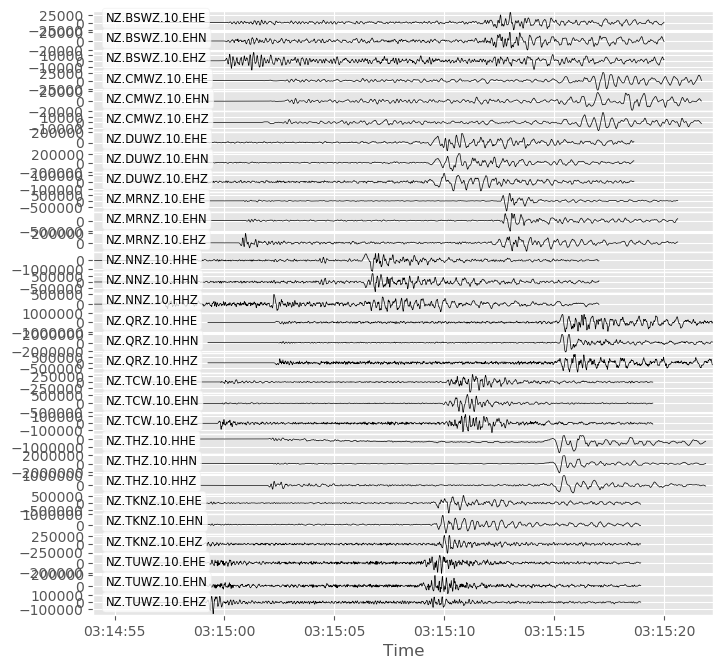

In [3]:
from seismic_picker import seismic_picker 
# note that you need to be in the directory that seismic_picker.py is located
from obspy.clients.fdsn import Client

from obspy import Stream
from obspy.core.event import ResourceIdentifier
from obspy.clients.fdsn import Client

event_id = "2018p546311"

client = Client("GEONET")
cat = client.get_events(eventid=event_id)
event = cat[0]
print("Event has {0} picks".format(len(event.picks)))
# We will remove the picks from strong motion sites, they often have poor timing
event.picks = [p for p in event.picks 
               if p.waveform_id.channel_code[0] != "B"]

# Lets just look at the first five picks
picks = sorted(event.picks, key=lambda p: p.time)[0:10]

st = Stream()
for pick in picks:
    tr = client.get_waveforms(
        network=pick.waveform_id.network_code,
        station=pick.waveform_id.station_code,
        location=pick.waveform_id.location_code,
        channel=pick.waveform_id.channel_code[0:-1] + "?",
        starttime=pick.time - 3, 
        endtime=pick.time + 20)
    tr.trim(pick.time - 3, pick.time +20)
    st += tr
st.merge().sort(["starttime"])

# Note that you can do some pre-processing, such as filtered, before calling the
# picking applet.  You can also give it the GeoNet event to plot their picks and
# edit those.

picked_event = seismic_picker(st)
# Because this event already has an ID number, you can add that in to the event
# to help you keep track of things:
picked_event.resource_id = ResourceIdentifier(id=event_id)

# You will want to save your picks after you are done. To do that use something like:
picked_event.write("{0}_picked.xml".format(event_id), format="QUAKEML")
# Note you should try and keep the event ID in the filename

You can change the event_id above and you will get a different event to pick.  Pick at least 10 and compare
your picks to the GeoNet picks.

You can re-load your picks using:

```python
from obspy import read_events

catalog = read_events("your-pickfile-here") # Replace with the file you want to read in
```